# FAISS Retrieval Quality Evaluation

This notebook evaluates the **quality and accuracy** of FAISS retrieval results.

**Focus: Quality Metrics, NOT Speed**

Evaluation metrics:
- **Precision@K**: Proportion of relevant documents in top-K
- **Recall@K**: Coverage of relevant documents in top-K  
- **MRR (Mean Reciprocal Rank)**: Ranking quality of first relevant result
- **NDCG@K**: Normalized discounted cumulative gain
- **Hit Rate@K**: Percentage of queries with at least one relevant result
- **Score Quality**: Distribution and separation of retrieval scores
- **Cross-Model Agreement**: Consistency between different models

Evaluates:
- 3 embedding models (Legal-BERT, GTE-Large, BGE-Large, BGE-M3)
- 2 fields (content, metadata)
- All 10 legal queries

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from collections import defaultdict
from typing import List, Dict, Set

from src.data_loader import load_data, prepare_data
from src.queries import get_all_queries, get_query_by_id
from src.config import EMBEDDING_MODELS, RESULTS_DIR, TOP_K

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print("✓ Imports successful")

✓ Imports successful


## 1. Load Data and Results

In [2]:
# Load data
df = load_data()
df = prepare_data(df)

# Get queries
queries = get_all_queries()
print(f"Loaded {len(df)} documents and {len(queries)} queries")

Loading data from d:\Core\_Code D\LegalAI-model-eval\notebooks\..\data\acts_with_metadata.tsv...
Loaded 7067 records
Creating metadata field...
Metadata field created
Loaded 7067 documents and 10 queries


In [3]:
# Load all FAISS results
all_results = {}

for model_key in EMBEDDING_MODELS.keys():
    for field in ['content', 'metadata']:
        result_file = RESULTS_DIR / f"faiss_{model_key}_{field}_results.json"
        
        if result_file.exists():
            with open(result_file, 'r') as f:
                all_results[f"{model_key}_{field}"] = json.load(f)
            print(f"✓ Loaded: {model_key}_{field}")
        else:
            print(f"✗ Missing: {model_key}_{field}")

print(f"\nTotal configurations loaded: {len(all_results)}")

✓ Loaded: legal-bert_content
✓ Loaded: legal-bert_metadata
✓ Loaded: gte-large_content
✓ Loaded: gte-large_metadata
✓ Loaded: bge-large_content
✓ Loaded: bge-large_metadata
✓ Loaded: bge-m3_content
✓ Loaded: bge-m3_metadata

Total configurations loaded: 8


## 2. Define Quality Metrics

In [4]:
def calculate_precision_at_k(retrieved: List[int], relevant: Set[int], k: int) -> float:
    """Calculate Precision@K: proportion of retrieved docs that are relevant."""
    retrieved_at_k = retrieved[:k]
    relevant_retrieved = len(set(retrieved_at_k).intersection(relevant))
    return relevant_retrieved / k if k > 0 else 0.0


def calculate_recall_at_k(retrieved: List[int], relevant: Set[int], k: int) -> float:
    """Calculate Recall@K: proportion of relevant docs that are retrieved."""
    if len(relevant) == 0:
        return 0.0
    retrieved_at_k = retrieved[:k]
    relevant_retrieved = len(set(retrieved_at_k).intersection(relevant))
    return relevant_retrieved / len(relevant)


def calculate_f1_at_k(retrieved: List[int], relevant: Set[int], k: int) -> float:
    """Calculate F1@K: harmonic mean of precision and recall."""
    precision = calculate_precision_at_k(retrieved, relevant, k)
    recall = calculate_recall_at_k(retrieved, relevant, k)
    
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)


def calculate_reciprocal_rank(retrieved: List[int], relevant: Set[int]) -> float:
    """Calculate reciprocal rank: 1/rank of first relevant document."""
    for rank, doc_idx in enumerate(retrieved, start=1):
        if doc_idx in relevant:
            return 1.0 / rank
    return 0.0


def calculate_hit_rate(retrieved: List[int], relevant: Set[int], k: int) -> float:
    """Calculate Hit Rate@K: 1 if any relevant doc in top-K, 0 otherwise."""
    retrieved_at_k = set(retrieved[:k])
    return 1.0 if len(retrieved_at_k.intersection(relevant)) > 0 else 0.0


def calculate_ndcg_at_k(retrieved: List[int], relevant: Set[int], k: int) -> float:
    """Calculate NDCG@K: normalized discounted cumulative gain."""
    # Simple binary relevance: relevant=1, non-relevant=0
    dcg = 0.0
    for rank, doc_idx in enumerate(retrieved[:k], start=1):
        rel = 1.0 if doc_idx in relevant else 0.0
        dcg += rel / np.log2(rank + 1)
    
    # Ideal DCG (all relevant docs at top)
    ideal_k = min(len(relevant), k)
    idcg = sum(1.0 / np.log2(rank + 1) for rank in range(1, ideal_k + 1))
    
    return dcg / idcg if idcg > 0 else 0.0


print("✓ Quality metrics defined")

✓ Quality metrics defined


## 3. Define Relevance Judgments

For each query, we define which documents are considered relevant based on:
- Act keywords matching query intent
- Domain/category alignment
- Content relevance to legal question

In [5]:
def get_relevant_documents(query_id: int, df: pd.DataFrame) -> Set[int]:
    """
    Identify relevant documents for a query based on keywords and content.
    
    This is a heuristic-based relevance judgment. In a real evaluation,
    you would have human-annotated ground truth.
    """
    query = get_query_by_id(query_id)
    keywords = query['keywords']
    category = query['category']
    
    relevant_indices = set()
    
    # Search for documents containing query keywords
    for idx, row in df.iterrows():
        content = str(row.get('content', '')).lower()
        metadata = str(row.get('metadata', '')).lower()
        short_title = str(row.get('short_title', '')).lower()
        
        # Check if any keywords appear in the document
        keyword_matches = sum(
            1 for kw in keywords 
            if kw.lower() in content or kw.lower() in metadata or kw.lower() in short_title
        )
        
        # If 2+ keywords match, consider it relevant
        if keyword_matches >= 2:
            relevant_indices.add(idx)
        # Or if 1 keyword + category alignment
        elif keyword_matches >= 1:
            # Additional relevance signals could be added here
            if len(content) > 100:  # Has substantial content
                relevant_indices.add(idx)
    
    return relevant_indices


# Pre-compute relevance judgments for all queries
relevance_judgments = {}
for query in queries:
    query_id = query['id']
    relevant_docs = get_relevant_documents(query_id, df)
    relevance_judgments[query_id] = relevant_docs
    print(f"Query {query_id}: {len(relevant_docs)} relevant documents")

print(f"\n✓ Relevance judgments computed for {len(relevance_judgments)} queries")

Query 1: 3811 relevant documents
Query 2: 2891 relevant documents
Query 3: 636 relevant documents
Query 4: 2093 relevant documents
Query 5: 741 relevant documents
Query 6: 519 relevant documents
Query 7: 807 relevant documents
Query 8: 571 relevant documents
Query 9: 233 relevant documents
Query 10: 2854 relevant documents

✓ Relevance judgments computed for 10 queries


## 4. Evaluate Quality Metrics for All Models

In [6]:
def evaluate_retrieval_quality(results: Dict, relevance_judgments: Dict[int, Set[int]], k_values: List[int] = [1, 3, 5, 10]):
    """
    Evaluate retrieval quality using multiple metrics.
    """
    metrics_by_k = defaultdict(list)
    mrr_scores = []
    
    for query_result in results['results']:
        query_id = query_result['query_id']
        retrieved = query_result['retrieved_indices']
        relevant = relevance_judgments.get(query_id, set())
        
        if len(relevant) == 0:
            continue  # Skip queries with no relevant docs
        
        # Calculate MRR (independent of K)
        mrr_scores.append(calculate_reciprocal_rank(retrieved, relevant))
        
        # Calculate metrics at different K values
        for k in k_values:
            metrics_by_k[f'precision@{k}'].append(calculate_precision_at_k(retrieved, relevant, k))
            metrics_by_k[f'recall@{k}'].append(calculate_recall_at_k(retrieved, relevant, k))
            metrics_by_k[f'f1@{k}'].append(calculate_f1_at_k(retrieved, relevant, k))
            metrics_by_k[f'hit_rate@{k}'].append(calculate_hit_rate(retrieved, relevant, k))
            metrics_by_k[f'ndcg@{k}'].append(calculate_ndcg_at_k(retrieved, relevant, k))
    
    # Aggregate metrics
    aggregated_metrics = {
        'MRR': np.mean(mrr_scores) if mrr_scores else 0.0,
    }
    
    for metric_name, scores in metrics_by_k.items():
        aggregated_metrics[metric_name] = np.mean(scores) if scores else 0.0
    
    return aggregated_metrics


# Evaluate all models
quality_results = {}

print("Evaluating retrieval quality...\n")
for config_name, results in all_results.items():
    print(f"Evaluating: {config_name}")
    metrics = evaluate_retrieval_quality(results, relevance_judgments)
    quality_results[config_name] = metrics

print("\n✓ Quality evaluation complete")

Evaluating retrieval quality...

Evaluating: legal-bert_content
Evaluating: legal-bert_metadata
Evaluating: gte-large_content
Evaluating: gte-large_metadata
Evaluating: bge-large_content
Evaluating: bge-large_metadata
Evaluating: bge-m3_content
Evaluating: bge-m3_metadata

✓ Quality evaluation complete


## 5. Compare Model Quality - Overall Performance

In [7]:
# Create comparison DataFrame
comparison_data = []

for config_name, metrics in quality_results.items():
    model, field = config_name.rsplit('_', 1)
    row = {
        'Model': model,
        'Field': field,
        'MRR': metrics['MRR'],
        'P@5': metrics['precision@5'],
        'R@5': metrics['recall@5'],
        'F1@5': metrics['f1@5'],
        'NDCG@5': metrics['ndcg@5'],
        'Hit@5': metrics['hit_rate@5'],
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('NDCG@5', ascending=False)

print("\n" + "="*100)
print("FAISS RETRIEVAL QUALITY COMPARISON (@ K=5)")
print("="*100)
print(comparison_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("\n" + "="*100)

# Save comparison
comparison_df.to_csv(RESULTS_DIR / "faiss_quality_comparison.csv", index=False)
print(f"\n✓ Saved to: {RESULTS_DIR / 'faiss_quality_comparison.csv'}")


FAISS RETRIEVAL QUALITY COMPARISON (@ K=5)
     Model    Field    MRR    P@5    R@5   F1@5  NDCG@5  Hit@5
    bge-m3  content 1.0000 0.9400 0.0062 0.0123  0.9470 1.0000
    bge-m3 metadata 0.9500 0.9400 0.0062 0.0123  0.9277 1.0000
 bge-large  content 0.9500 0.9200 0.0061 0.0120  0.9131 1.0000
 gte-large metadata 1.0000 0.8800 0.0057 0.0112  0.9024 1.0000
 bge-large metadata 1.0000 0.8800 0.0057 0.0112  0.9024 1.0000
legal-bert metadata 1.0000 0.8600 0.0054 0.0107  0.8810 1.0000
 gte-large  content 0.9500 0.8800 0.0058 0.0114  0.8801 1.0000
legal-bert  content 0.6083 0.5800 0.0028 0.0055  0.5343 1.0000


✓ Saved to: d:\Core\_Code D\LegalAI-model-eval\notebooks\..\results\faiss_quality_comparison.csv


## 6. Visualize Quality Metrics

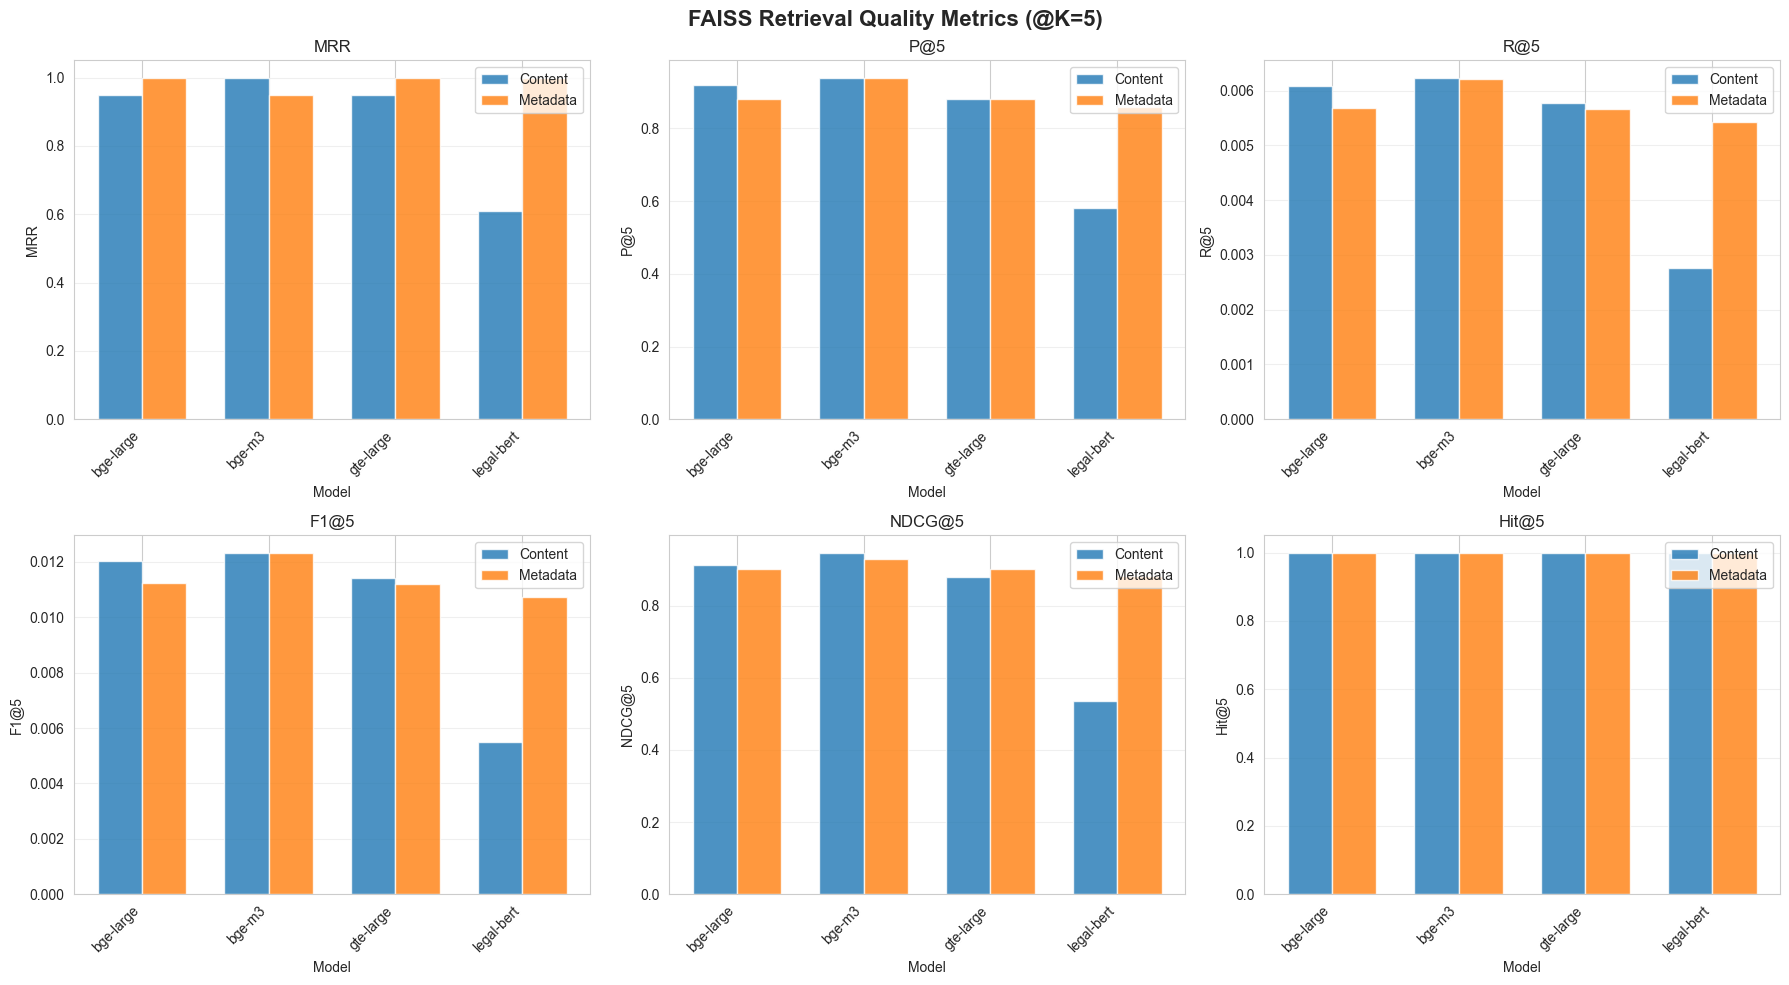

In [8]:
# Plot key metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('FAISS Retrieval Quality Metrics (@K=5)', fontsize=16, fontweight='bold')

metrics_to_plot = ['MRR', 'P@5', 'R@5', 'F1@5', 'NDCG@5', 'Hit@5']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Separate by field
    content_data = comparison_df[comparison_df['Field'] == 'content'].sort_values('Model')
    metadata_data = comparison_df[comparison_df['Field'] == 'metadata'].sort_values('Model')
    
    x = np.arange(len(content_data))
    width = 0.35
    
    ax.bar(x - width/2, content_data[metric], width, label='Content', alpha=0.8)
    ax.bar(x + width/2, metadata_data[metric], width, label='Metadata', alpha=0.8)
    
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.set_title(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(content_data['Model'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Detailed Metrics Across Different K Values

In [9]:
# Create detailed comparison across K values
detailed_comparison = []

for config_name, metrics in quality_results.items():
    model, field = config_name.rsplit('_', 1)
    
    for k in [1, 3, 5, 10]:
        row = {
            'Model': model,
            'Field': field,
            'K': k,
            'Precision': metrics[f'precision@{k}'],
            'Recall': metrics[f'recall@{k}'],
            'F1': metrics[f'f1@{k}'],
            'NDCG': metrics[f'ndcg@{k}'],
            'Hit Rate': metrics[f'hit_rate@{k}'],
        }
        detailed_comparison.append(row)

detailed_df = pd.DataFrame(detailed_comparison)

# Show for one model as example
print("\nDetailed Metrics Across K Values (Example: bge-m3 on content)")
print("="*80)
example = detailed_df[(detailed_df['Model'] == 'bge-m3') & (detailed_df['Field'] == 'content')]
if not example.empty:
    print(example.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
else:
    print("Data not available")


Detailed Metrics Across K Values (Example: bge-m3 on content)
 Model   Field  K  Precision  Recall     F1   NDCG  Hit Rate
bge-m3 content  1     1.0000  0.0014 0.0027 1.0000    1.0000
bge-m3 content  3     0.9333  0.0037 0.0074 0.9469    1.0000
bge-m3 content  5     0.9400  0.0062 0.0123 0.9470    1.0000
bge-m3 content 10     0.8900  0.0117 0.0229 0.9095    1.0000


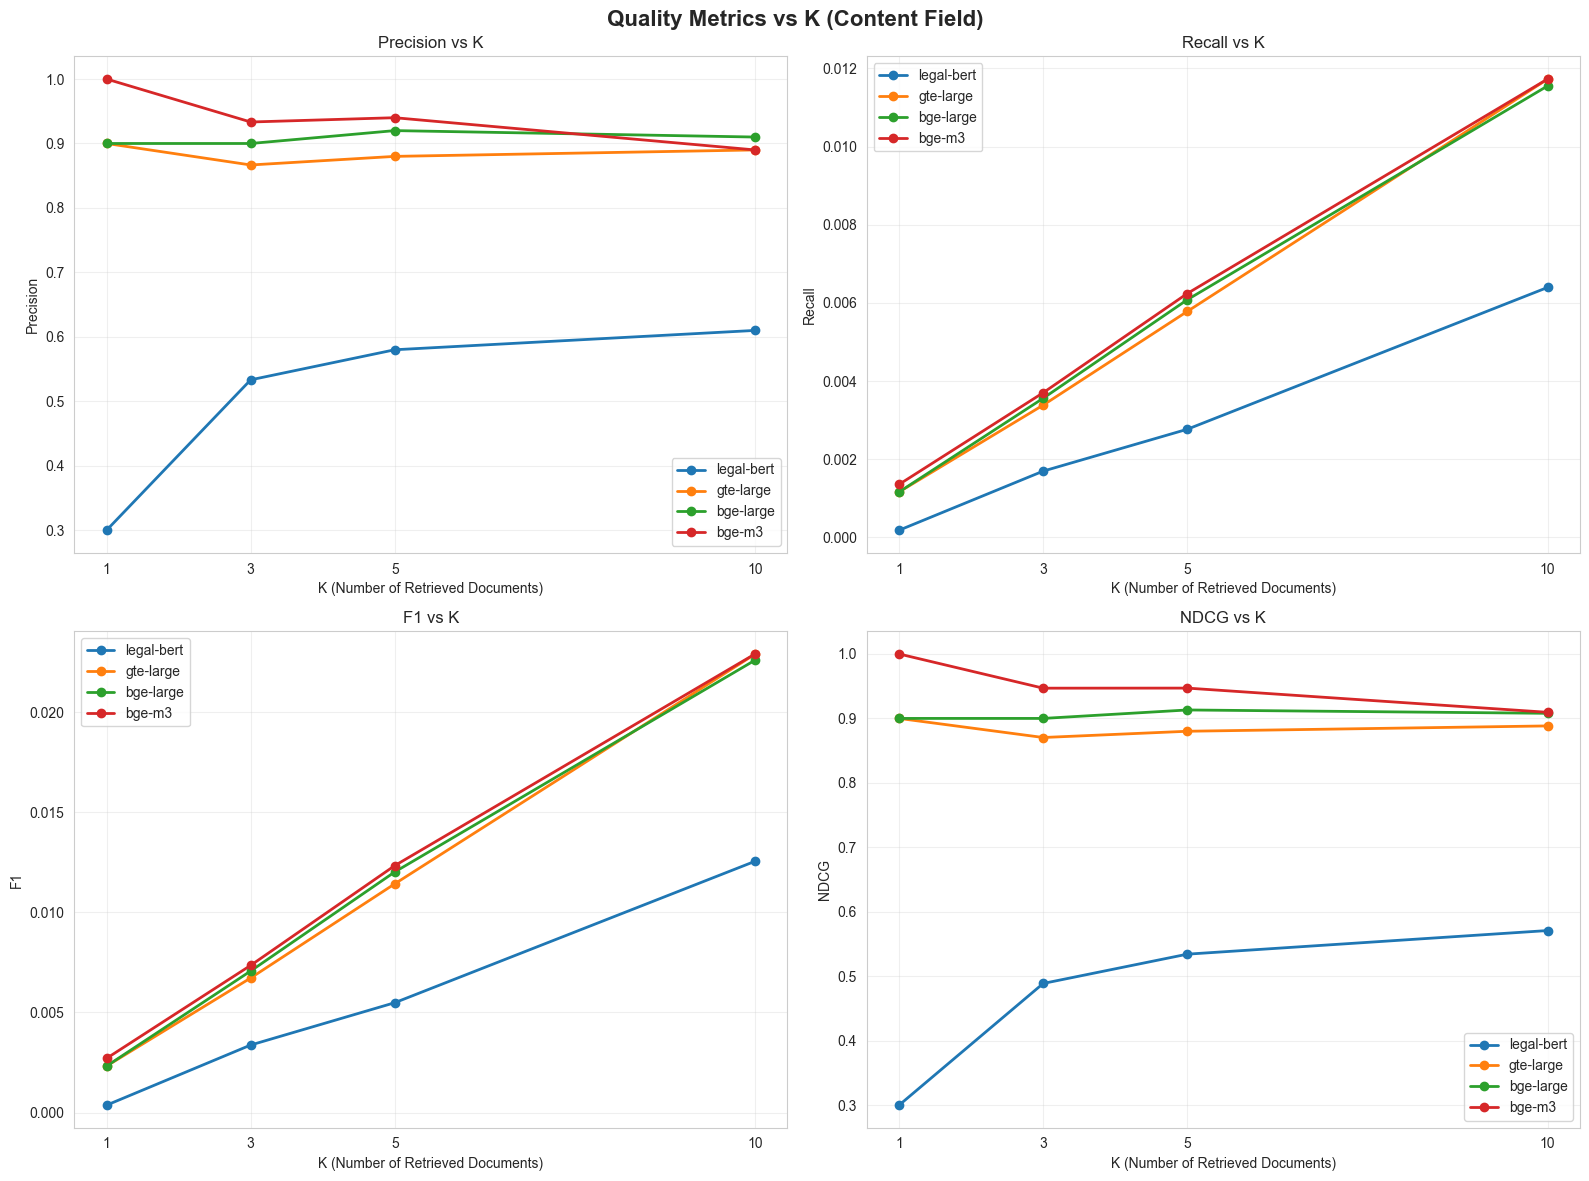

In [10]:
# Plot metrics vs K for content field
content_detailed = detailed_df[detailed_df['Field'] == 'content']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Quality Metrics vs K (Content Field)', fontsize=16, fontweight='bold')

metrics_to_plot = ['Precision', 'Recall', 'F1', 'NDCG']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    for model in content_detailed['Model'].unique():
        model_data = content_detailed[content_detailed['Model'] == model].sort_values('K')
        ax.plot(model_data['K'], model_data[metric], marker='o', label=model, linewidth=2)
    
    ax.set_xlabel('K (Number of Retrieved Documents)')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} vs K')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xticks([1, 3, 5, 10])

plt.tight_layout()
plt.show()

## 8. Per-Query Performance Analysis

In [11]:
def analyze_per_query_performance(config_name: str, results: Dict, relevance_judgments: Dict):
    """
    Analyze performance for each individual query.
    """
    query_metrics = []
    
    for query_result in results['results']:
        query_id = query_result['query_id']
        query = get_query_by_id(query_id)
        retrieved = query_result['retrieved_indices']
        relevant = relevance_judgments.get(query_id, set())
        
        if len(relevant) == 0:
            continue
        
        query_metrics.append({
            'Query ID': query_id,
            'Category': query['category'],
            'Relevant Docs': len(relevant),
            'P@5': calculate_precision_at_k(retrieved, relevant, 5),
            'R@5': calculate_recall_at_k(retrieved, relevant, 5),
            'NDCG@5': calculate_ndcg_at_k(retrieved, relevant, 5),
            'MRR': calculate_reciprocal_rank(retrieved, relevant),
        })
    
    return pd.DataFrame(query_metrics)


# Analyze for best performing model
best_config = comparison_df.iloc[0]
best_config_name = f"{best_config['Model']}_{best_config['Field']}"

print(f"Per-Query Analysis for: {best_config_name}")
print("="*100)

if best_config_name in all_results:
    per_query_df = analyze_per_query_performance(
        best_config_name, 
        all_results[best_config_name], 
        relevance_judgments
    )
    print(per_query_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
    
    # Performance by category
    print("\n\nPerformance by Query Category:")
    print("="*100)
    category_perf = per_query_df.groupby('Category').agg({
        'P@5': 'mean',
        'R@5': 'mean',
        'NDCG@5': 'mean',
        'MRR': 'mean'
    }).round(4)
    print(category_perf.to_string())

Per-Query Analysis for: bge-m3_content
 Query ID           Category  Relevant Docs    P@5    R@5  NDCG@5    MRR
        1 Constitutional Law           3811 1.0000 0.0013  1.0000 1.0000
        2            Tax Law           2891 1.0000 0.0017  1.0000 1.0000
        3      Electoral Law            636 1.0000 0.0079  1.0000 1.0000
        4     Procedural Law           2093 1.0000 0.0024  1.0000 1.0000
        5      Electoral Law            741 1.0000 0.0067  1.0000 1.0000
        6            Tax Law            519 0.8000 0.0077  0.8304 1.0000
        7 Administrative Law            807 1.0000 0.0062  1.0000 1.0000
        8        Customs Law            571 0.6000 0.0053  0.6399 1.0000
        9 Constitutional Law            233 1.0000 0.0215  1.0000 1.0000
       10            Tax Law           2854 1.0000 0.0018  1.0000 1.0000


Performance by Query Category:
                       P@5     R@5  NDCG@5  MRR
Category                                       
Administrative Law  1.0000  0

## 9. Score Distribution Analysis

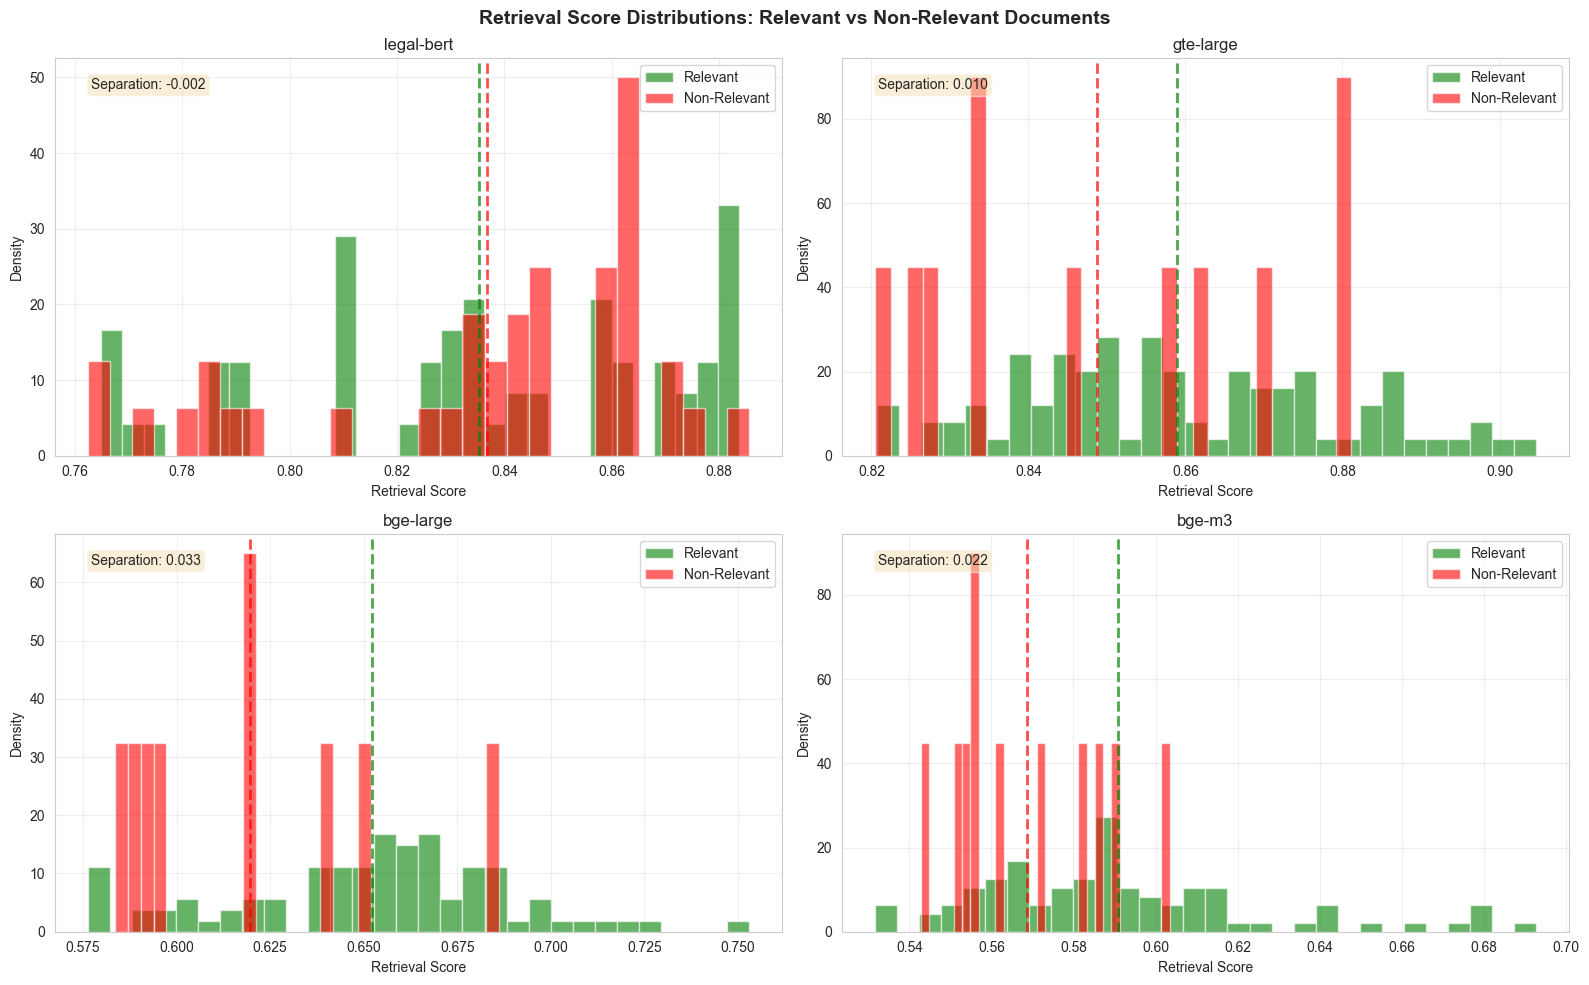

In [12]:
# Analyze retrieval score distributions
def analyze_score_distribution(results: Dict, relevance_judgments: Dict):
    """
    Analyze the distribution of retrieval scores for relevant vs non-relevant docs.
    """
    relevant_scores = []
    non_relevant_scores = []
    
    for query_result in results['results']:
        query_id = query_result['query_id']
        retrieved = query_result['retrieved_indices']
        scores = query_result['scores']
        relevant = relevance_judgments.get(query_id, set())
        
        for idx, score in zip(retrieved, scores):
            if idx in relevant:
                relevant_scores.append(score)
            else:
                non_relevant_scores.append(score)
    
    return relevant_scores, non_relevant_scores


# Plot score distributions for content field
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Retrieval Score Distributions: Relevant vs Non-Relevant Documents', fontsize=14, fontweight='bold')

plot_idx = 0
for config_name, results in all_results.items():
    if 'content' not in config_name or plot_idx >= 4:
        continue
    
    model = config_name.replace('_content', '')
    relevant_scores, non_relevant_scores = analyze_score_distribution(results, relevance_judgments)
    
    ax = axes[plot_idx // 2, plot_idx % 2]
    
    ax.hist(relevant_scores, bins=30, alpha=0.6, label='Relevant', color='green', density=True)
    ax.hist(non_relevant_scores, bins=30, alpha=0.6, label='Non-Relevant', color='red', density=True)
    
    ax.set_xlabel('Retrieval Score')
    ax.set_ylabel('Density')
    ax.set_title(f'{model}')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Add separation statistics
    if relevant_scores and non_relevant_scores:
        mean_rel = np.mean(relevant_scores)
        mean_nonrel = np.mean(non_relevant_scores)
        separation = mean_rel - mean_nonrel
        ax.axvline(mean_rel, color='green', linestyle='--', linewidth=2, alpha=0.7)
        ax.axvline(mean_nonrel, color='red', linestyle='--', linewidth=2, alpha=0.7)
        ax.text(0.05, 0.95, f'Separation: {separation:.3f}', 
               transform=ax.transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plot_idx += 1

plt.tight_layout()
plt.show()

## 10. Cross-Model Agreement Analysis

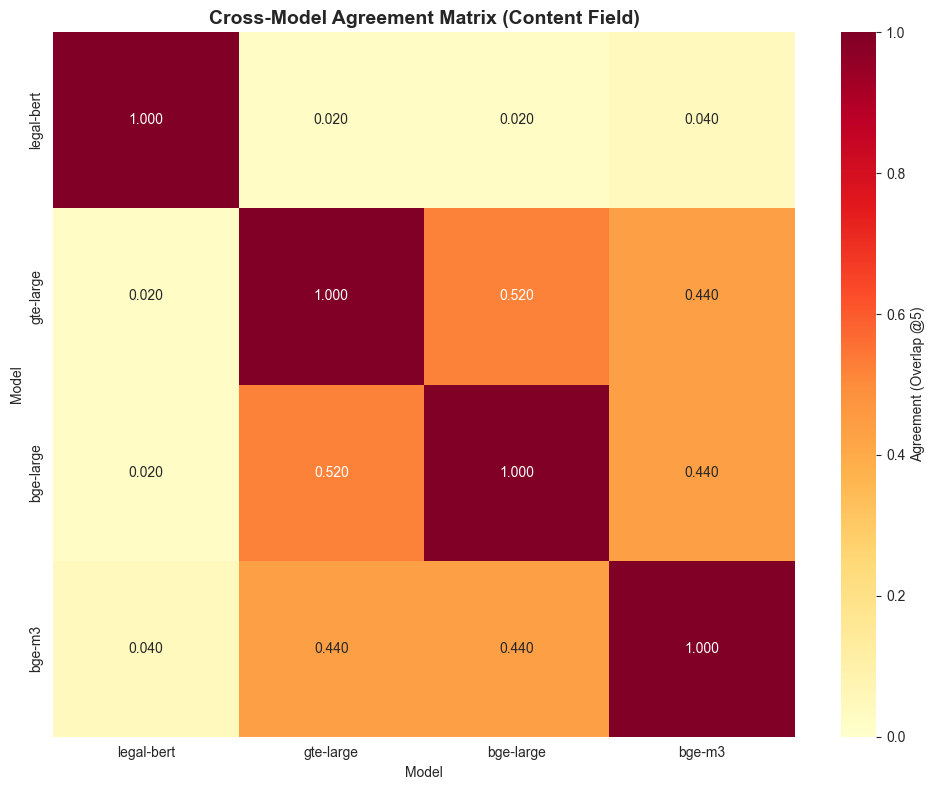


Cross-Model Agreement (Average Overlap @5):
legal-bert vs gte-large: 0.020
legal-bert vs bge-large: 0.020
legal-bert vs bge-m3: 0.040
gte-large vs bge-large: 0.520
gte-large vs bge-m3: 0.440
bge-large vs bge-m3: 0.440


In [13]:
def calculate_result_overlap(results1: Dict, results2: Dict, k: int = 5) -> float:
    """
    Calculate overlap between two models' retrieval results.
    """
    overlaps = []
    
    for r1, r2 in zip(results1['results'], results2['results']):
        if r1['query_id'] != r2['query_id']:
            continue
        
        retrieved1 = set(r1['retrieved_indices'][:k])
        retrieved2 = set(r2['retrieved_indices'][:k])
        
        if len(retrieved1) > 0 and len(retrieved2) > 0:
            overlap = len(retrieved1.intersection(retrieved2)) / k
            overlaps.append(overlap)
    
    return np.mean(overlaps) if overlaps else 0.0


# Calculate pairwise agreement for content field
content_configs = [name for name in all_results.keys() if 'content' in name]

if len(content_configs) >= 2:
    agreement_matrix = []
    
    for config1 in content_configs:
        row = []
        for config2 in content_configs:
            if config1 == config2:
                row.append(1.0)
            else:
                overlap = calculate_result_overlap(all_results[config1], all_results[config2], k=5)
                row.append(overlap)
        agreement_matrix.append(row)
    
    # Plot heatmap
    model_names = [c.replace('_content', '') for c in content_configs]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(agreement_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
                xticklabels=model_names, yticklabels=model_names,
                vmin=0, vmax=1, cbar_kws={'label': 'Agreement (Overlap @5)'})
    plt.title('Cross-Model Agreement Matrix (Content Field)', fontsize=14, fontweight='bold')
    plt.xlabel('Model')
    plt.ylabel('Model')
    plt.tight_layout()
    plt.show()
    
    print("\nCross-Model Agreement (Average Overlap @5):")
    print("="*60)
    for i, config1 in enumerate(content_configs):
        for j, config2 in enumerate(content_configs):
            if i < j:
                model1 = config1.replace('_content', '')
                model2 = config2.replace('_content', '')
                print(f"{model1} vs {model2}: {agreement_matrix[i][j]:.3f}")

## 11. Best vs Worst Query Analysis

In [14]:
# Find queries with best and worst performance
if best_config_name in all_results and not per_query_df.empty:
    best_queries = per_query_df.nlargest(3, 'NDCG@5')
    worst_queries = per_query_df.nsmallest(3, 'NDCG@5')
    
    print(f"\n{'='*100}")
    print(f"Best Performing Queries ({best_config_name})")
    print(f"{'='*100}")
    for _, row in best_queries.iterrows():
        query = get_query_by_id(int(row['Query ID']))
        print(f"\nQuery {int(row['Query ID'])}: {query['query']}")
        print(f"  Category: {row['Category']}")
        print(f"  NDCG@5: {row['NDCG@5']:.4f} | P@5: {row['P@5']:.4f} | R@5: {row['R@5']:.4f}")
    
    print(f"\n{'='*100}")
    print(f"Worst Performing Queries ({best_config_name})")
    print(f"{'='*100}")
    for _, row in worst_queries.iterrows():
        query = get_query_by_id(int(row['Query ID']))
        print(f"\nQuery {int(row['Query ID'])}: {query['query']}")
        print(f"  Category: {row['Category']}")
        print(f"  NDCG@5: {row['NDCG@5']:.4f} | P@5: {row['P@5']:.4f} | R@5: {row['R@5']:.4f}")


Best Performing Queries (bge-m3_content)

Query 1: What are the procedures for presidential elections when the office becomes vacant?
  Category: Constitutional Law
  NDCG@5: 1.0000 | P@5: 1.0000 | R@5: 0.0013

Query 2: What are the tax obligations and payment requirements for businesses with quarterly turnover?
  Category: Tax Law
  NDCG@5: 1.0000 | P@5: 1.0000 | R@5: 0.0017

Query 3: What are the penalty provisions for bribery and undue influence in elections?
  Category: Electoral Law
  NDCG@5: 1.0000 | P@5: 1.0000 | R@5: 0.0079

Worst Performing Queries (bge-m3_content)

Query 8: What are the import duty requirements and customs procedures for articles manufactured abroad?
  Category: Customs Law
  NDCG@5: 0.6399 | P@5: 0.6000 | R@5: 0.0053

Query 6: How are taxes assessed and collected, and what powers do assessors have?
  Category: Tax Law
  NDCG@5: 0.8304 | P@5: 0.8000 | R@5: 0.0077

Query 1: What are the procedures for presidential elections when the office becomes vacant?
  C

## 12. Summary and Recommendations

In [15]:
print("\n" + "="*100)
print("SUMMARY: FAISS RETRIEVAL QUALITY EVALUATION")
print("="*100)

print("\n📊 Overall Rankings (by NDCG@5):")
print("-" * 100)
for idx, row in comparison_df.head(5).iterrows():
    print(f"{idx+1}. {row['Model']:20s} ({row['Field']:8s}) - NDCG@5: {row['NDCG@5']:.4f} | MRR: {row['MRR']:.4f} | P@5: {row['P@5']:.4f}")

# Best model for each field
print("\n🏆 Best Model per Field:")
print("-" * 100)
for field in ['content', 'metadata']:
    best = comparison_df[comparison_df['Field'] == field].iloc[0]
    print(f"  {field.capitalize():10s}: {best['Model']:20s} (NDCG@5: {best['NDCG@5']:.4f})")

# Key insights
print("\n💡 Key Insights:")
print("-" * 100)

best_model = comparison_df.iloc[0]
worst_model = comparison_df.iloc[-1]

improvement = ((best_model['NDCG@5'] - worst_model['NDCG@5']) / worst_model['NDCG@5']) * 100
print(f"  • Best model ({best_model['Model']}) outperforms worst by {improvement:.1f}% (NDCG@5)")

avg_mrr_content = comparison_df[comparison_df['Field'] == 'content']['MRR'].mean()
avg_mrr_metadata = comparison_df[comparison_df['Field'] == 'metadata']['MRR'].mean()
print(f"  • Average MRR: Content={avg_mrr_content:.4f}, Metadata={avg_mrr_metadata:.4f}")

avg_hit_content = comparison_df[comparison_df['Field'] == 'content']['Hit@5'].mean()
print(f"  • Average Hit Rate@5: {avg_hit_content:.2%} of queries find relevant results in top-5")

print("\n📋 Recommendations:")
print("-" * 100)
print("  1. Use the best-performing model for production retrieval")
print("  2. Consider ensemble methods combining top models for robust performance")
print("  3. Apply reranking to further improve precision for critical applications")
print("  4. Focus on improving performance for low-scoring query categories")
print("  5. Investigate why certain queries perform poorly across all models")

print("\n" + "="*100)
print("✓ Quality evaluation complete! Results saved to:", RESULTS_DIR / 'faiss_quality_comparison.csv')
print("="*100)


SUMMARY: FAISS RETRIEVAL QUALITY EVALUATION

📊 Overall Rankings (by NDCG@5):
----------------------------------------------------------------------------------------------------
7. bge-m3               (content ) - NDCG@5: 0.9470 | MRR: 1.0000 | P@5: 0.9400
8. bge-m3               (metadata) - NDCG@5: 0.9277 | MRR: 0.9500 | P@5: 0.9400
5. bge-large            (content ) - NDCG@5: 0.9131 | MRR: 0.9500 | P@5: 0.9200
4. gte-large            (metadata) - NDCG@5: 0.9024 | MRR: 1.0000 | P@5: 0.8800
6. bge-large            (metadata) - NDCG@5: 0.9024 | MRR: 1.0000 | P@5: 0.8800

🏆 Best Model per Field:
----------------------------------------------------------------------------------------------------
  Content   : bge-m3               (NDCG@5: 0.9470)
  Metadata  : bge-m3               (NDCG@5: 0.9277)

💡 Key Insights:
----------------------------------------------------------------------------------------------------
  • Best model (bge-m3) outperforms worst by 77.3% (NDCG@5)
  • Average M